In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
#PARÂMETROS DOMINIO
L = 2
tf = 80

#PARAMETROS
D = 0.0039
p = 0.0453
c0 = 8e3
Dl = D / (p * L**2)

#PARÂMETROS TREINAMENTO
N_DOMAIN = 1000
N_BOUNDARY = 1000
N_INITIAL = 1000
EPOCHS = 5000

#PARAMETRO ADIMENCIONALIZADO
S_DOM = (0, L / L)
T_DOM = (0, tf * p)

#DECLARAÇÃO DOMÍNIO ESPACIAL E TEMPORAL
geom = dde.geometry.Interval(S_DOM[0], S_DOM[1])
time = dde.geometry.TimeDomain(T_DOM[0], T_DOM[1])
geomtime = dde.geometry.GeometryXTime(geom, time)

#EQUAÇÃO RESIDUAL
def pde(x, c):
    c_t = dde.grad.jacobian(c, x, i=0, j=1)
    c_xx = dde.grad.hessian(c, x, i=0, j=0)
    return c_t - (Dl * c_xx + c)

#CONDIÇÃO INICIAL
def ic_func(x): return L**3 * np.exp(-100 * x[:, 0:1]**2)
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def bc_func(x): return 0
BC = dde.icbc.DirichletBC(geomtime, bc_func, lambda _, on_boundary: on_boundary)

#DECLARAÇÃO TREINAMENTO
DATA = dde.data.TimePDE(
    geomtime,
    pde,
    [IC, BC],
    num_domain = N_DOMAIN,
    num_boundary = N_BOUNDARY,
    num_initial = N_INITIAL,
)

LAYERS = [2] + [60] * 3 + [1]
ACTIVATION = "tanh"
INIT = "Glorot uniform"
NET = dde.nn.FNN(LAYERS, ACTIVATION, INIT)

#COMPILAÇÃO
MODEL = dde.Model(DATA, NET)
MODEL.compile("adam", lr=1e-3)
losshistory, train_state = MODEL.train(iterations=EPOCHS)


Compiling model...
'compile' took 0.793548 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.52e-02, 4.11e+00, 3.66e-02]    [4.52e-02, 4.11e+00, 3.66e-02]    []  


/home/henriquewsl/.local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [1.22e-02, 4.55e-02, 8.96e-02]    [1.22e-02, 4.55e-02, 8.96e-02]    []  
2000      [9.27e-03, 3.71e-02, 6.33e-02]    [9.27e-03, 3.71e-02, 6.33e-02]    []  
3000      [1.79e-02, 3.01e-02, 5.53e-02]    [1.79e-02, 3.01e-02, 5.53e-02]    []  
4000      [2.14e-03, 2.73e-02, 4.74e-02]    [2.14e-03, 2.73e-02, 4.74e-02]    []  
5000      [5.85e-03, 2.49e-02, 4.32e-02]    [5.85e-03, 2.49e-02, 4.32e-02]    []  

Best model at step 5000:
  train loss: 7.39e-02
  test loss: 7.39e-02
  test metric: []

'train' took 56.453825 s



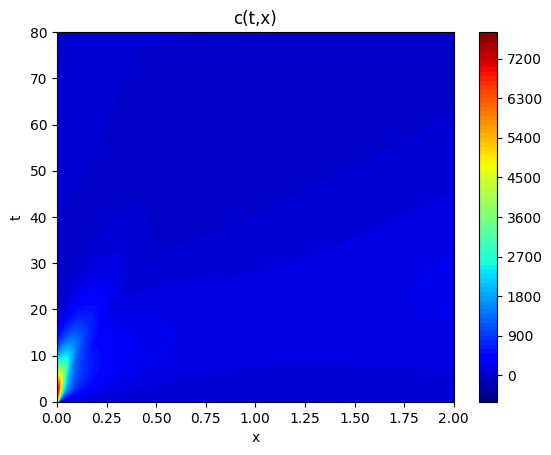

In [3]:
import matplotlib.pyplot as plt

SIZE = 1000
X, T = np.meshgrid(
    np.linspace(S_DOM[0], S_DOM[1], SIZE),
    np.linspace(T_DOM[0], T_DOM[1], SIZE)
)
INPUT = np.vstack((np.ravel(X), np.ravel(T))).T
OUT = MODEL.predict(INPUT)
OUT = np.reshape(OUT, (SIZE,SIZE)).T


plt.contourf(X * L, T / p, OUT * c0 / L**3, 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()


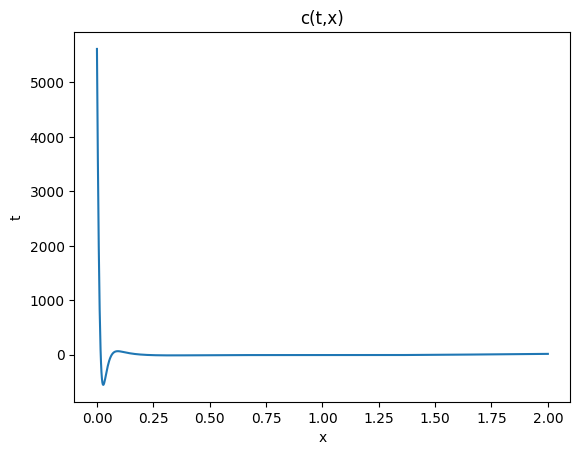

In [4]:
plt.plot(X[0] * L, OUT[0] * c0 / L**3)
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()

In [5]:
#CONDIÇÃO INICIAL
def ic_func(x): return L**3 * np.exp(-100 * x[:, 0:1]**2)
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def bc_func(x): return L**3 - x[:, 0:1] * L**3
BC = dde.icbc.DirichletBC(geomtime, bc_func, lambda _, on_boundary: on_boundary)

#DECLARAÇÃO TREINAMENTO
DATA = dde.data.TimePDE(
    geomtime,
    pde,
    [IC, BC],
    num_domain = N_DOMAIN,
    num_boundary = N_BOUNDARY,
    num_initial = N_INITIAL,
)

LAYERS = [2] + [60] * 3 + [1]
ACTIVATION = "tanh"
INIT = "Glorot uniform"
NET = dde.nn.FNN(LAYERS, ACTIVATION, INIT)

#COMPILAÇÃO
MODEL = dde.Model(DATA, NET)
MODEL.compile("adam", lr=1e-3)
losshistory, train_state = MODEL.train(iterations=EPOCHS)

Compiling model...
'compile' took 0.000200 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.14e-01, 4.04e+00, 3.23e+01]    [1.14e-01, 4.04e+00, 3.23e+01]    []  
1000      [1.89e-01, 4.66e-02, 1.40e-02]    [1.89e-01, 4.66e-02, 1.40e-02]    []  
2000      [4.36e-02, 1.04e-02, 3.83e-03]    [4.36e-02, 1.04e-02, 3.83e-03]    []  
3000      [1.88e-02, 5.13e-03, 3.57e-03]    [1.88e-02, 5.13e-03, 3.57e-03]    []  
4000      [1.15e-02, 3.20e-03, 4.32e-03]    [1.15e-02, 3.20e-03, 4.32e-03]    []  
5000      [9.00e-03, 2.44e-03, 4.41e-03]    [9.00e-03, 2.44e-03, 4.41e-03]    []  

Best model at step 5000:
  train loss: 1.59e-02
  test loss: 1.59e-02
  test metric: []

'train' took 53.397245 s



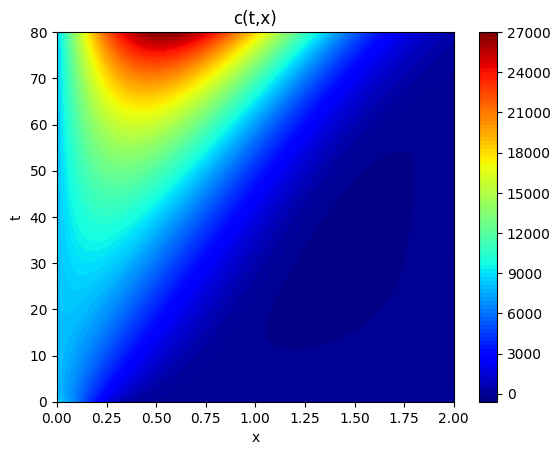

In [6]:
import matplotlib.pyplot as plt

SIZE = 1000
x, t = np.meshgrid(
    np.linspace(S_DOM[0], S_DOM[1], SIZE),
    np.linspace(T_DOM[0], T_DOM[1], SIZE)
)
INPUT = np.vstack((np.ravel(X), np.ravel(T))).T
OUT = MODEL.predict(INPUT)
OUT = np.reshape(OUT, (SIZE,SIZE))


plt.contourf(X * L, T / p, OUT * c0 / L**3, 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()


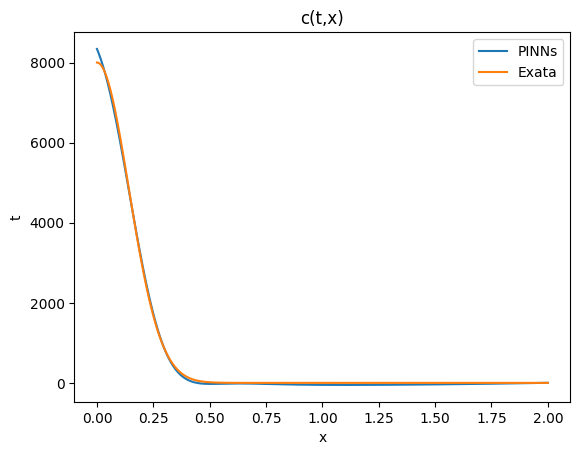

In [7]:
plt.plot(X[0] * L, OUT[0] * c0 / L**3, label = 'PINNs')
plt.plot(X[0] * L, (L*10)**3 * np.exp(-100 * X[0]**2), label = 'Exata')
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.legend()
plt.show()

In [8]:
#CONDIÇÃO INICIAL
def ic_func(x): return L**3 * np.exp(-100 * x[:, 0:1]**2)
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def boundary_l(x, on_boundary): return on_boundary and np.isclose(x[0], 0)
def boundary_r(x, on_boundary): return on_boundary and np.isclose(x[0], 1)

def bc_func(x): return L**3 - x[:, 0:1] * L**3
BC1 = dde.icbc.DirichletBC(geomtime, lambda x: L**3, boundary_l)
BC2 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_r)

#DECLARAÇÃO TREINAMENTO
DATA = dde.data.TimePDE(
    geomtime,
    pde,
    [IC, BC1, BC2],
    num_domain = N_DOMAIN,
    num_boundary = N_BOUNDARY,
    num_initial = N_INITIAL,
)

LAYERS = [2] + [60] * 3 + [1]
ACTIVATION = "tanh"
INIT = "Glorot uniform"
NET = dde.nn.FNN(LAYERS, ACTIVATION, INIT)

#COMPILAÇÃO
MODEL = dde.Model(DATA, NET)
MODEL.compile("adam", lr=1e-3)
losshistory, train_state = MODEL.train(iterations=EPOCHS)

Compiling model...
'compile' took 0.000202 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.45e-01, 4.06e+00, 5.83e+01, 3.88e-01]    [1.45e-01, 4.06e+00, 5.83e+01, 3.88e-01]    []  
1000      [5.29e-01, 8.88e-02, 2.64e-02, 6.52e-03]    [5.29e-01, 8.88e-02, 2.64e-02, 6.52e-03]    []  
2000      [1.74e-01, 3.34e-02, 5.38e-03, 4.72e-03]    [1.74e-01, 3.34e-02, 5.38e-03, 4.72e-03]    []  
3000      [4.62e-02, 1.20e-02, 3.77e-03, 1.48e-03]    [4.62e-02, 1.20e-02, 3.77e-03, 1.48e-03]    []  
4000      [2.11e-02, 6.74e-03, 2.12e-03, 3.93e-03]    [2.11e-02, 6.74e-03, 2.12e-03, 3.93e-03]    []  
5000      [1.63e-02, 4.27e-03, 2.47e-03, 4.86e-03]    [1.63e-02, 4.27e-03, 2.47e-03, 4.86e-03]    []  

Best model at step 5000:
  train loss: 2.79e-02
  test loss: 2.79e-02
  test metric: []

'train' took 60.641449 s



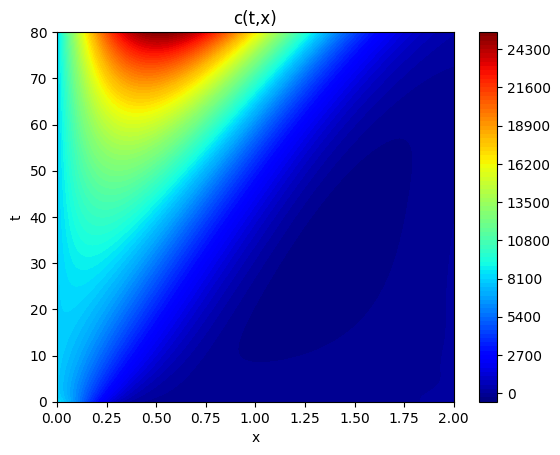

In [9]:
import matplotlib.pyplot as plt

SIZE = 1000
X, T = np.meshgrid(
    np.linspace(S_DOM[0], S_DOM[1], SIZE),
    np.linspace(T_DOM[0], T_DOM[1], SIZE)
)
INPUT = np.vstack((np.ravel(X), np.ravel(T))).T
OUT = MODEL.predict(INPUT)
OUT = np.reshape(OUT, (SIZE,SIZE))


#fig, ax = plt.subplots(1, 2)

#ax[0].contourf(X * L, T / p, OUT * c0 / L**3, 100, cmap = 'jet')
#ax[1].plot(X[0] * L, OUT[0] * c0 / L**3, label = 'PINNs')

plt.contourf(X * L, T / p, OUT * c0 / L**3, 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()

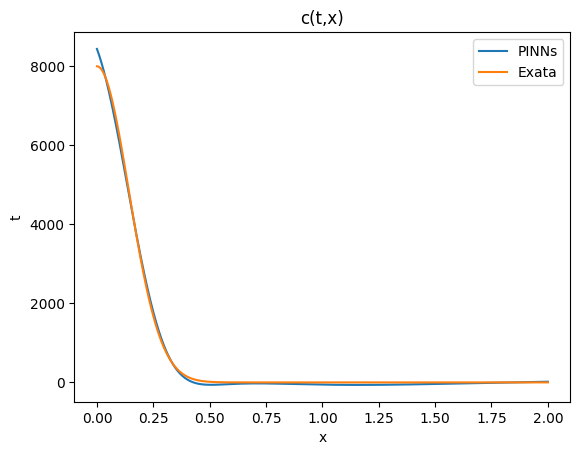

In [10]:
plt.plot(X[0] * L, OUT[0] * c0 / L**3, label = 'PINNs')
plt.plot(X[0] * L, (L*10)**3 * np.exp(-100 * X[0]**2), label = 'Exata')
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.legend()
plt.show()

In [32]:
#GPU
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

#NÚMERO DE PONTOS DE TREINAMENTO
NUM = 3000

#EPOCHS
EPOCHS = 6000

#CONDIÇÃO INICIAL
def ic_func(x): return L**3 * np.exp(-100 * x[:, 0:1]**2)
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def boundary(x, on_boundary): return on_boundary and geom.on_boundary(x)

def neumann_bc(x): 
    
    #n = geom.boundary_normal(x)
    return 0
    
BC = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary, component = 0)
#BC2 = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary, component = 1)

#DECLARAÇÃO TREINAMENTO
DATA = dde.data.TimePDE(
    geomtime,
    pde,
    [IC, BC],
    num_domain = NUM,
    num_boundary = NUM,
    num_initial = NUM,
)

#TOPOLOGIA DA REDE
LAYERS = [2] + [100] * 3 + [1]
ACTIVATION = "tanh"
INIT = "Glorot uniform"
NET = dde.nn.FNN(LAYERS, ACTIVATION, INIT)

#COMPILAÇÃO
MODEL = dde.Model(DATA, NET)
MODEL.compile("adam", lr=1e-3)
losshistory, train_state = MODEL.train(iterations=EPOCHS)

Compiling model...
'compile' took 0.000222 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.69e-01, 4.05e+00, 1.96e-02]    [2.69e-01, 4.05e+00, 1.96e-02]    []  
1000      [2.02e-01, 5.09e-02, 3.03e-01]    [2.02e-01, 5.09e-02, 3.03e-01]    []  
2000      [1.78e-01, 3.07e-02, 4.17e-03]    [1.78e-01, 3.07e-02, 4.17e-03]    []  
3000      [1.68e-01, 2.75e-02, 8.24e-04]    [1.68e-01, 2.75e-02, 8.24e-04]    []  
4000      [1.60e-01, 2.53e-02, 2.21e-03]    [1.60e-01, 2.53e-02, 2.21e-03]    []  
5000      [1.51e-01, 2.73e-02, 1.20e-02]    [1.51e-01, 2.73e-02, 1.20e-02]    []  
6000      [1.42e-01, 2.42e-02, 7.34e-04]    [1.42e-01, 2.42e-02, 7.34e-04]    []  

Best model at step 6000:
  train loss: 1.67e-01
  test loss: 1.67e-01
  test metric: []

'train' took 74.445038 s



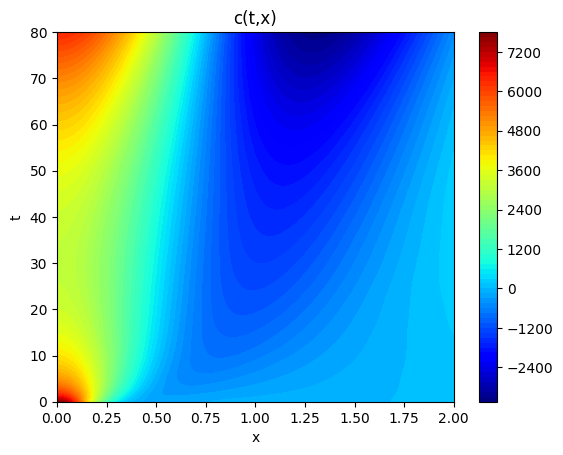

In [33]:
import matplotlib.pyplot as plt

SIZE = 1000
X, T = np.meshgrid(
    np.linspace(S_DOM[0], S_DOM[1], SIZE),
    np.linspace(T_DOM[0], T_DOM[1], SIZE)
)
INPUT = np.vstack((np.ravel(X), np.ravel(T))).T
OUT = MODEL.predict(INPUT)
OUT = np.reshape(OUT, (SIZE,SIZE))


plt.contourf(X * L, T / p, OUT * c0 / L**3, 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()

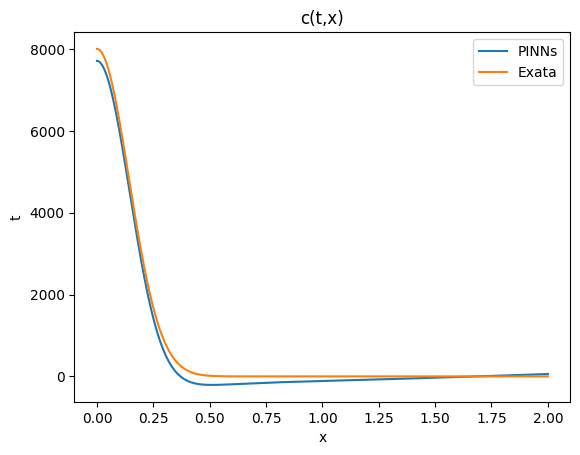

In [34]:
plt.plot(X[0] * L, OUT[0] * c0 / L**3, label = 'PINNs')
plt.plot(X[0] * L, (L*10)**3 * np.exp(-100 * X[0]**2), label = 'Exata')
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.legend()
plt.show()